### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2022
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Aprendizaje No Supervisado

Integrantes:
* Fernando Agustin Cardellino
* Adrian Zelaya

### Objetivos:

Encontrar los temas comunes a los documentos, sin tener en cuenta al fuero al que pertenecen.

* Realizar Topic Modeling utilizando LDA (Latent Dirichlet Allocation) y (NMF) Non-negative Matrix Factorization sobre el corpus. 

* Evaluar velocidad de proceso para saber cuál de los dos es más rápido y cual tiene la agrupación de tópicos más cercana a lo que podrían ser clases válidas para la agrupación de documentos. Es decir, si se corresponden al fuero originario: penal, laboral, familia o menores.

Opcional:

* Realizar el proceso utilizando Gensim-Doc2Vec. Generar un input texto y traer los tres documentos con mayor similitud semántica al texto ingresado

Fecha de Entrega: 26 de agosto de 2022

In [1]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from scikitplot.metrics import plot_roc
import warnings
warnings.filterwarnings("ignore")
#import nltk
#nltk.download('stopwords')  # Descomentar para bajar las stopwords
# Ref: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [2]:
# Cargamos modelo de spacy y stopwords de NLTK
nlp = spacy.load("es_core_news_sm")

CURR_DIR = os.getcwd()  # Gets current directory
STOPWORDS_ES = stopwords.words('spanish')
BREAKPOINT=None  # None para analizar todos los documentos, sino un número para analizar hasta n documentos

In [3]:
def getListOfFiles(dirName, return_dir=False):
    # create a list of file and sub directories
    # names in the given directory
    files = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for file in files:
        # Create full path
        fullPath = os.path.join(dirName, file)
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            if return_dir:
                allFiles.append(fullPath.split(os.sep)[-1])
            else:
                allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles

In [4]:
# Funciones de preprocesamiento

def get_tokens(files_path, fuero_name=None, breakpoint=None, object_type=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si `breakpoint` != None, dar el número de docs con el que se interrumpe la función
    object_type: indica el tipo de objeto que devuelve, i.e. 'token'/None (SpaCy object `token`), 
    'word' (texto/string) or 'entity' (SpaCy object `entity`) 
    """
    def get_conditions(token, case):
        if case == 'entity':
            return True
        else:
            return token.is_alpha and not token.is_stop
    
    corpus = [] # En esta lista guardamos diccionarios con data de cada documento

    tokens = [] # En esta lista guardamos los tokens de todo el documento

    i = 0
    for filename in getListOfFiles(files_path):
        tokens_ = [] # En esta lista guardamos los tokens por documento
        file_name = filename.split(os.sep)[-1]
        # extraemos el nombre del fuero a partir de la carpeta en donde reside el documento:
        fuero = fuero_name if fuero_name is not None else filename.split(os.sep)[-2]

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()
            # Tokenizamos el corpus
            nlp_doc = nlp(file_text)            
            
            iterable = nlp_doc.ents if object_type == 'entity' else nlp_doc
            
            for token in iterable:
                if get_conditions(token, case=object_type):
                    # lematizamos y pasamos a minúscula (en modo 'palabras'/'word' solamente)
                    aux_token = token.lemma_.lower() if object_type == 'word' else token
                    
                    # insertamos los tokens en la lista de todos los tokens
                    tokens.append(
                        aux_token
                    )
                    # insertamos los tokens en la lista de los tokens específicos al documento
                    tokens_.append(
                        aux_token
                    )
            # insertamos la data del documento a la lista reservada para tal fin
            corpus.append({
                'id': i, 'archivo': file_name, 'fuero': fuero, 'texto': file_text, 'texto_clean': tokens_
            })
        
        i += 1            
        # cortamos la ejecución de acuerdo al valor de quiebre (usado para testeo)
        if breakpoint:
            if i > breakpoint:
                break
    
    return tokens, pd.DataFrame(corpus)


def get_lemmas_stem_from_tokens(tokens, stemmer, language='spanish'):
    aux_dict = {
        'word': [token.lower_ for token in tokens],
        'lemma': [token.lemma_.lower() for token in tokens],
        'stem': [stemmer.stem(token.lower_) for token in tokens]
    }
    return pd.DataFrame(aux_dict)
    
    
def get_conteo_palabras(palabras):
    """Función que genera un pandas DataFrame con la frecuencia de las palabras
    """
    palabras_df = pd.DataFrame([{'palabra': str(x).lower()} for x in palabras])
    # print(corpus_df.head())

    return palabras_df.groupby(['palabra'])['palabra'].count().sort_values(ascending=False)

    
def generar_corpus(file_path, breakpoint, fuero_name=None, verbose=True, object_type='word'):
    if verbose:
        print("Generamos Corpus de palabras y conteo de frecuencias")
    
    # Generamos el corpus de palabras, y el diccionario con el mapeo de los fueros con sus respectivos documentos
    palabras, corpus = get_tokens(file_path, fuero_name=fuero_name, breakpoint=breakpoint, object_type='word')

    frecuencia_palabras_df = get_conteo_palabras(palabras)
    
    if verbose:
        print(f"Algunas palabras: {palabras[:5]}")
    
    return frecuencia_palabras_df, palabras, corpus


def vectorize_corpus(vectorizer, corpus):
    """
    Función que vectoriza un corpus de palabras compuesto por documentos, utilizando cualquier vectorizador de 
    scikit-learn que sea ingresado por el usuario.
    Se asume que el corpus ya se encuentra tokenizado (mediante la función generar_corpus()), por lo que se 'anula'
    el tokenizador por defecto de los vectorizadores.
    """
    vectorizer_ = vectorizer(
        tokenizer=lambda doc: doc, # Pisamos el tokenizador para que tome los tokens como vienen (ver descripción)
        lowercase=False # Paso ya incluido en nuestro preprocesamiento
    )
    return vectorizer_, vectorizer_.fit_transform(corpus)

In [5]:
# Ubicación de los documentos
filesDir = os.path.join(CURR_DIR, "Documentos") # Use 'Testing' for testing

# Obtenemos lista de los fueros
fueros = getListOfFiles(filesDir, return_dir=True)

In [6]:
n_docs = BREAKPOINT if not None else 'todos'
    
print(f"\nAnálisis para {n_docs} documentos\n")

frecuencia_palabras_df, corpus, corpus_df = generar_corpus(filesDir, BREAKPOINT, object_type='word', verbose=False)

print(corpus[:10])

display(frecuencia_palabras_df.head())

display(corpus_df.head())


Análisis para None documentos

['sala', 'laboral', 'tribunal', 'superior', 'protocolo', 'sentencias', 'nº', 'resolución', 'año', 'tomo']


palabra
fs         4463
art        4146
ley        3121
auto       2574
recurso    2570
Name: palabra, dtype: int64

id                                            archivo    fuero  \
0   0                          9 BAEZ-FLECHA BUS.pdf.txt  LABORAL   
1   1                            90 FUNES-COYSPU.pdf.txt  LABORAL   
2   2                     1 QUINTEROS-CONSOLIDAR.pdf.txt  LABORAL   
3   3  3 SANGUEDOLCE-MUNICIPALIDAD DE VILLA ALLENDE.p...  LABORAL   
4   4                        188 LUCIANO-NICOLAS.pdf.txt  LABORAL   

                                               texto  \
0  SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...   
1  SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...   
2  SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...   
3  SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...   
4  SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...   

                                         texto_clean  
0  [sala, laboral, tribunal, superior, protocolo,...  
1  [sala, laboral, tribunal, superior, protocolo,...  
2  [sala, laboral, tribunal, superior, protocolo,...  
3  [sala, laboral, tribunal, superior, protocolo,...  
4  [sala, laboral, tribunal, superior, protocolo,...

In [7]:
# CountVectorizer

tf_vectorizer, tf = vectorize_corpus(CountVectorizer, corpus_df['texto_clean'])#corpus)

tf_feature_names = tf_vectorizer.get_feature_names_out()

tf_feature_names

array(['aa', 'aag', 'aam', ..., 'úrsula', 'útero', 'útil'], dtype=object)

In [8]:
tfidf_vectorizer, tfidf = vectorize_corpus(TfidfVectorizer, corpus_df['texto_clean'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

tf_feature_names

array(['aa', 'aag', 'aam', ..., 'úrsula', 'útero', 'útil'], dtype=object)

In [9]:
### Agregar un poco de marco teórico de LDA y NMF
#### https://blog.mlreview.com/topic-modeling-with-scikit-learn-e80d33668730
#### https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation
#### https://www.youtube.com/watch?v=mZbHN41C-hw >>> Usando Latent Dirichlet Allocation LDA para separar articulos por temas Luis Serrano
#### https://www.youtube.com/watch?v=MvG4dPplrRo >>> Introduction to Document Similarity
#### https://www.youtube.com/watch?v=pmwQwyfoBOY >>> Word2vec - De la teoría a la práctica usando gensim
#### https://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/

In [10]:
n_topics = 4 # Familia, menores, laboral, penal

In [11]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Run NMF
nmf = NMF(n_components=n_topics, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5,
          init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0).fit(tf)

In [12]:
nmf.components_.shape

(4, 18713)

In [13]:
def plot_top_words(model, feature_names, n_top_words, title, n_x=2, n_y=2):
    ### From sckit-learn https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    fig, axes = plt.subplots(n_x, n_y, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

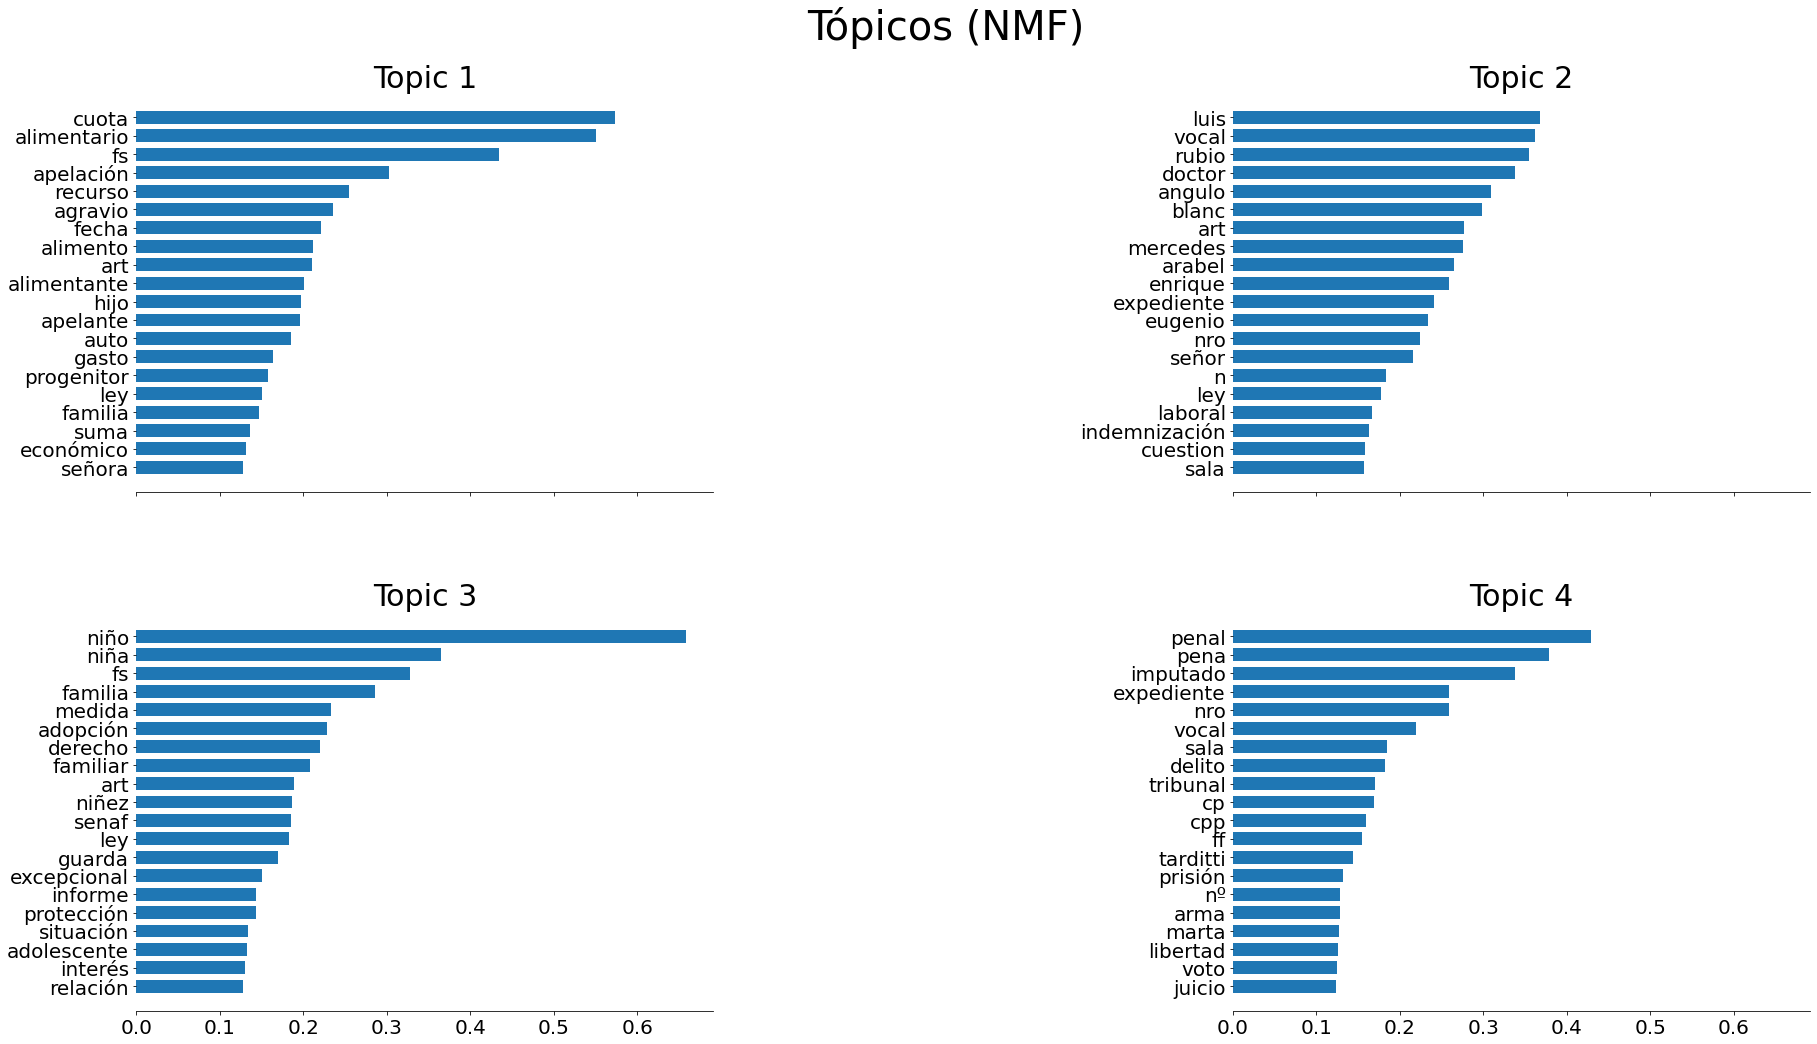

In [14]:
n_top_words = 20


#NMF

plot_top_words(nmf, tf_feature_names, n_top_words, title="Tópicos (NMF)")

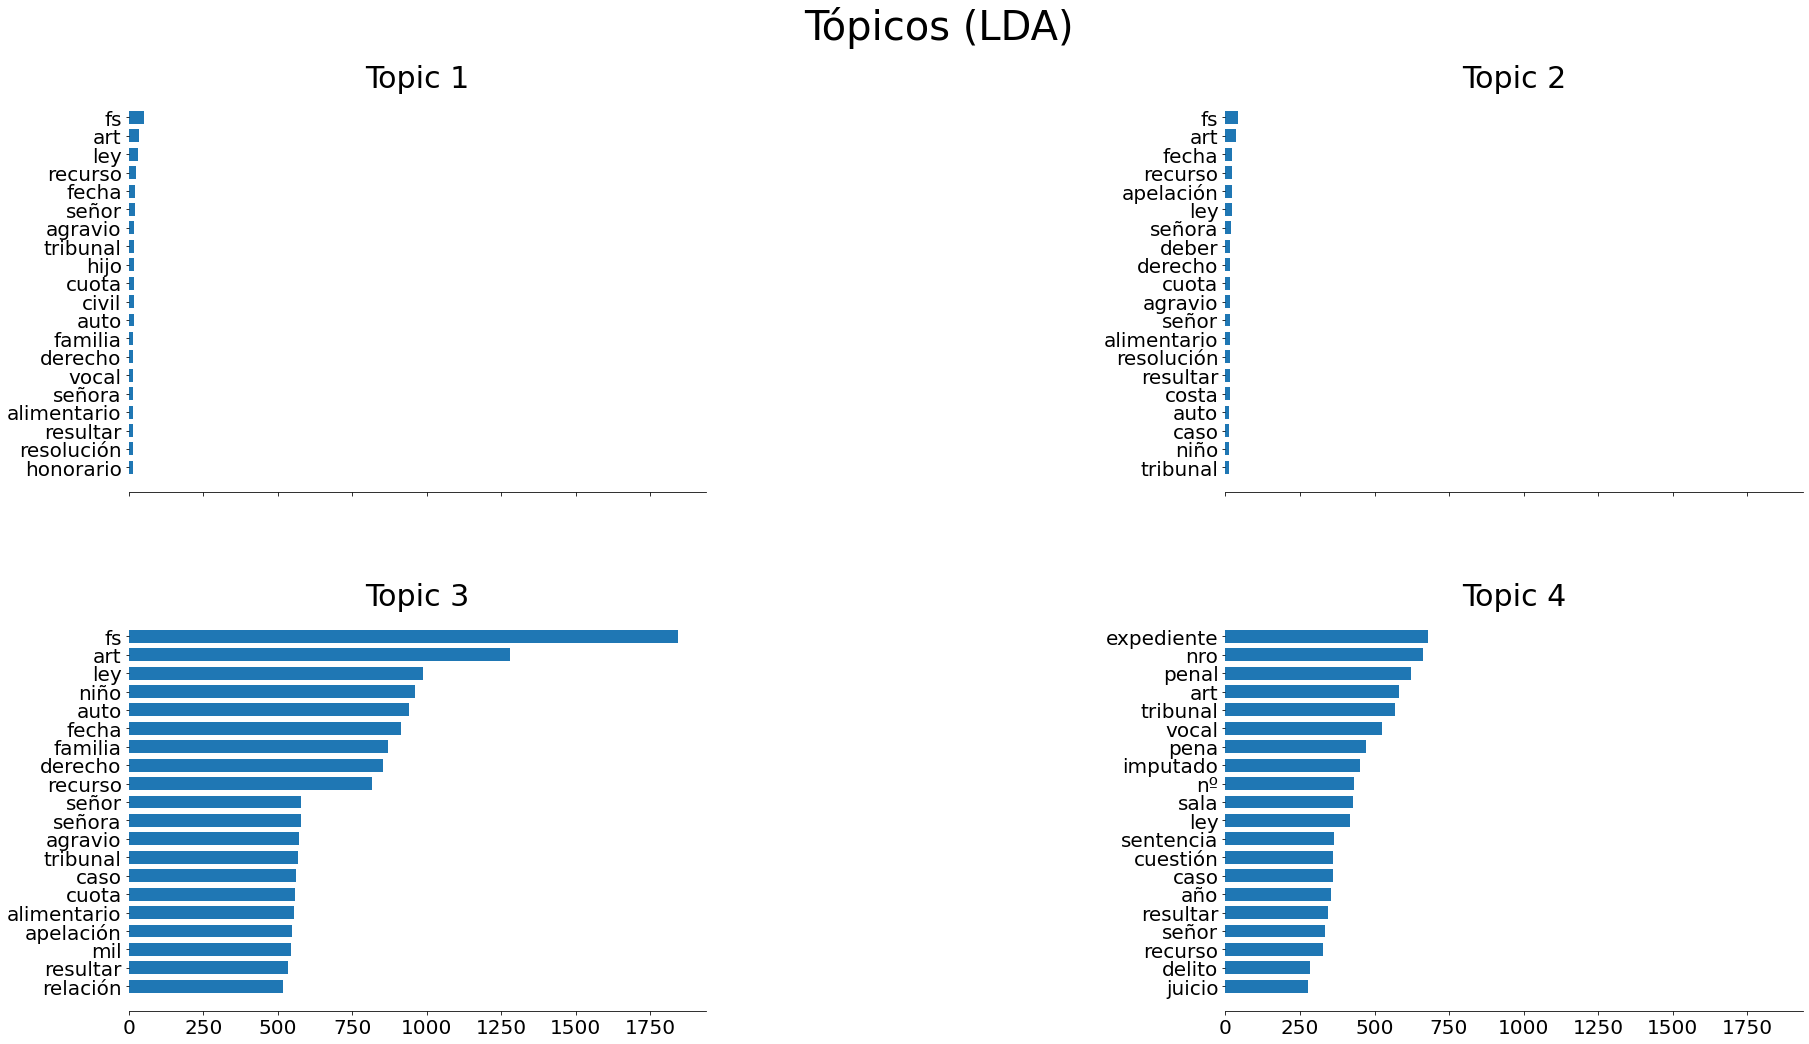

In [15]:
plot_top_words(lda, tf_feature_names, n_top_words, title="Tópicos (LDA)")

## Gensim 
(generating similar)

In [16]:
### Gensim: https://analyticsindiamag.com/how-to-implement-a-doc2vec-model-using-gensim/

import gensim
#import gensim.downloader as api
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


In [17]:
array_docs = corpus_df['texto_clean'].values

In [18]:
array_docs.shape

(243,)

In [19]:
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield TaggedDocument(words=list_of_words, tags=[i])
        
tagged_docs = [*tagged_document(array_docs)]

tagged_docs


[TaggedDocument(words=['sala', 'laboral', 'tribunal', 'superior', 'protocolo', 'sentencias', 'nº', 'resolución', 'año', 'tomo', 'folio', 'despido', 'expediente', 'baez', 'pablo', 'adrian', 'flecha', 'bus', 'viajes', 'ordinario', 'sentencia', 'numero', 'cordoba', 'reúnir', 'integrante', 'sala', 'laboral', 'tribunal', 'superior', 'justicia', 'doctor', 'luis', 'enrique', 'rubio', 'mercedes', 'blanc', 'arabel', 'luis', 'eugenio', 'angulo', 'presidencia', 'nombrado', 'dictar', 'sentencia', 'auto', 'baez', 'pablo', 'adrian', 'flecha', 'bus', 'viajes', 'ordinario', 'despido', 'recurso', 'casacion', 'raíz', 'recurso', 'concedido', 'actoro', 'sentencia', 'n', 'dictado', 'sala', 'novena', 'cámara', 'única', 'trabajo', 'constituido', 'tribunal', 'unipersonal', 'cargo', 'señor', 'juez', 'doctor', 'pedro', 'antonio', 'grasso', 'n', 'cuyo', 'copia', 'obra', 'fs', 'vta', 'resolver', 'rechazar', 'parte', 'demanda', 'incoado', 'pablo', 'adrian', 'baez', 'dni', 'flecha', 'bus', 'viajes', 'costa', 'difer

In [20]:
## https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
max_epochs = 100
vec_size = 20 # Default es 100, probar otras opciones
alpha = 0.025 # The initial learning rate

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1) # means ‘distributed memory’ (PV-DM), preserves the word order in a document
  
model.build_vocab(tagged_docs)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_docs,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [21]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
filesDir_test = os.path.join(CURR_DIR, "Testing-2")
_, __, test_corpus = generar_corpus(filesDir_test, BREAKPOINT, object_type='word', verbose=False)

test_data = test_corpus['texto_clean'].values[0]#word_tokenize("I love chatbots".lower())
inferred_vector = model.infer_vector(test_data)
print("V1_infer", inferred_vector)


# to find most similar doc using tags
similar_doc = model.dv.most_similar([inferred_vector], topn=len(model.dv))#model.docvecs.most_similar('0')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs[0])
#So doc2vec is as simple as this. Hope you guys liked it. Feel free to comment . Here is link to my blog for older version of gensim, you guys can also view that. https://medium.com/@mishra.thedeepak/doc2vec-in-a-simple-way-fa80bfe81104



V1_infer [ 0.4379396   1.23676    -3.524294   -0.58489496 -3.3694694  -0.18929109
  5.487734    7.2272115  -1.4563801   0.14510049 -3.7515008   2.04776
  1.6202499  -2.4849594  -0.9765483   0.36853006 -2.2816184   1.8727816
 -3.1767385  -4.25563   ]
[(144, 0.9791010022163391), (130, 0.9778092503547668), (97, 0.9569948315620422), (232, 0.8770685195922852), (67, 0.8475723266601562), (89, 0.8423161506652832), (235, 0.8387060165405273), (138, 0.8214678168296814), (135, 0.8179998397827148), (129, 0.7935274839401245), (109, 0.7884223461151123), (230, 0.742878794670105), (225, 0.7317556142807007), (124, 0.7291271686553955), (154, 0.7167211174964905), (79, 0.7081142067909241), (111, 0.7057337760925293), (221, 0.7032493352890015), (57, 0.6981785297393799), (217, 0.6939091682434082), (158, 0.6930374503135681), (222, 0.6842778325080872), (231, 0.6765178442001343), (214, 0.6659759879112244), (229, 0.6640655398368835), (224, 0.6637746095657349), (121, 0.661666989326477), (93, 0.660762369632721), (1

In [22]:
def get_most_similar_docs(model, train_corpus):
    ranks = []
    second_ranks = []
    for doc_id in range(len(train_corpus)):
        inferred_vector = model.infer_vector(train_corpus[doc_id].words)
        sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
        rank = [docid for docid, sim in sims].index(doc_id)
        ranks.append(rank)
        second_ranks.append(sims[1])
    return ranks, second_ranks



In [23]:
ranks, second_ranks = get_most_similar_docs(model, tagged_docs)#, inferred_vector)

In [24]:
ranks

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 1,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

In [25]:
second_ranks

[(0, 0.9278039336204529),
 (17, 0.8273299336433411),
 (25, 0.7398248314857483),
 (16, 0.8634181022644043),
 (26, 0.7727187871932983),
 (17, 0.8767752647399902),
 (30, 0.7614929676055908),
 (3, 0.8987321257591248),
 (13, 0.8232880234718323),
 (14, 0.9021405577659607),
 (25, 0.7665683627128601),
 (1, 0.7133504152297974),
 (15, 0.8716719746589661),
 (1, 0.8096232414245605),
 (17, 0.8546447157859802),
 (17, 0.8884896636009216),
 (13, 0.818247377872467),
 (15, 0.8154465556144714),
 (1, 0.8379916548728943),
 (1, 0.8848578929901123),
 (8, 0.9167840480804443),
 (1, 0.8933268189430237),
 (8, 0.813143789768219),
 (13, 0.8794230818748474),
 (15, 0.8486770391464233),
 (17, 0.7538518905639648),
 (6, 0.813747763633728),
 (1, 0.8866239786148071),
 (30, 0.8555519580841064),
 (25, 0.8253791928291321),
 (17, 0.8372259140014648),
 (17, 0.9025766849517822),
 (6, 0.8054606914520264),
 (36, 0.8935925960540771),
 (34, 0.8991097807884216),
 (17, 0.829513669013977),
 (17, 0.8729541301727295),
 (132, 0.91897541